# Hand Gesture Modeling using TFLite Model Maker


---



### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [ ]:
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0
!pip install -q mycolorpy

### Import the required packages.

In [ ]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from mycolorpy import colorlist as mcp
import numpy as np

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
from random import randrange
import numpy as np
from matplotlib.colors import hsv_to_rgb, to_hex
from PIL import Image, ImageDraw, ImageFont
from matplotlib.pyplot import figure

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

#mount your google drive if you use hosted runtime
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
def draw_image(image, results, size):
    result_size = len(results)
    for idx, obj in enumerate(results):
        # Prepare image for drawing
        draw = ImageDraw.Draw(image)

        # Prepare boundary box
        xmin, ymin, xmax, ymax = obj['bounding_box']
        xmin = int(xmin * size[1])
        xmax = int(xmax * size[1])
        ymin = int(ymin * size[0])
        ymax = int(ymax * size[0])

        #print(size)

        # Draw rectangle to desired thickness
        for x in range( 0, 10 ):
            color = tuple(np.random.choice(range(256), size=3))
            draw.rectangle((ymin, xmin, ymax, xmax), outline=color, width=5)
        display_str = labels[obj['class_id']] + ": " + str(round(obj['score']*100, 2)) + "%"
        draw.rectangle((ymin+5, xmin+10, ymin+len(display_str)*10, xmin+35), fill='black')
        draw.text((ymin+10,xmin+15), display_str)#, font=ImageFont.truetype("./utils/Neusharp-Bold.otf", 16))

    displayImage = np.asarray( image )
    #display(Image.fromarray(displayImage))
    st.image(displayImage)

### Create Dataframe from Images & PascalVOC Annotations (from `LabelImg`)

#### Training Set

In [158]:
# training set
df_train = pd.DataFrame(columns=['type','path','label','XMin','YMin','XMax','YMax'])
df_train.head()

# path to the image files
path_to_images = "your_own_path/data_for_object_detection/data/"

# path to the annotation files (in xml format)
directory_in_str = "your_own_path/data_for_object_detection/xml/"
directory = os.fsencode(directory_in_str)

for file in os.listdir(directory):
    filename = os.fsdecode(file)

    if filename.endswith(".xml"):
        name = os.path.splitext(filename)[0]
        path = directory_in_str + filename
        
        # X divided by the width
        # Y divided by the height
        # how to calculate normalized coordinates: https://stackoverflow.com/questions/48915003/get-the-bounding-box-coordinates-in-the-tensorflow-object-detection-api-tutorial

        tree = ET.parse(path)
        root = tree.getroot()
        image_name = path_to_images + root.find('filename').text
        
        for size in root.findall('size'):
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            
        for object in root.findall('object'):
            label_type = object.find('name').text
            for bndbox in object.findall('bndbox'):
                xmin = int(bndbox.find('xmin').text) / width
                xmax = int(bndbox.find('xmax').text) / width
                ymin = int(bndbox.find('ymin').text) / height
                ymax = int(bndbox.find('ymax').text) / height
                
                new_row = {
                 'type':"TRAIN",
                 'path':image_name,
                 'label':label_type,
                 'XMin':xmin,
                 'YMin':ymin,
                 'XMax':xmax,
                 'YMax':ymax,
                 }

                df_train = df_train.append(new_row, ignore_index=True)

df_train.head(2)

type                                               path    label    XMin  \
0  TRAIN  F:/Downloads/projects/hand-gestures/data_for_o...  option3  0.7365   
1  TRAIN  F:/Downloads/projects/hand-gestures/data_for_o...  option3  0.2470   

       YMin    XMax      YMax  
0  0.274536  0.8210  0.526525  
1  0.365341  0.4655  0.880720

In [443]:
# check the number of annotations in each train class
df_train.label.value_counts().to_frame()

label
option3    101
back       100
ok         100
option1    100
option2    100
option4    100
thumb      100
punch      100

### Testing Set

In [188]:
# test set
df_test = pd.DataFrame(columns=['type','path','label','XMin','YMin','XMax','YMax'])
df_test.head()

# path to the images file of test set
path_to_images = "your_path/data_for_object_detection/test/data/"

# path to the annotation files (in xml format) of test set
directory_in_str = "your_path/data_for_object_detection/test/xml/"
directory = os.fsencode(directory_in_str)

for file in os.listdir(directory):
    filename = os.fsdecode(file)

    if filename.endswith(".xml"):
        name = os.path.splitext(filename)[0]
        path = directory_in_str + filename

        tree = ET.parse(path)
        root = tree.getroot()
        image_name = path_to_images + root.find('filename').text
        
        for size in root.findall('size'):
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            
        for object in root.findall('object'):
            label_type = object.find('name').text
            for bndbox in object.findall('bndbox'):
                xmin = int(bndbox.find('xmin').text) / width
                xmax = int(bndbox.find('xmax').text) / width
                ymin = int(bndbox.find('ymin').text) / height
                ymax = int(bndbox.find('ymax').text) / height
                
                new_row = {
                 'type':"TRAIN",
                 'path':image_name,
                 'label':label_type,
                 'XMin':xmin,
                 'YMin':ymin,
                 'XMax':xmax,
                 'YMax':ymax,
                 }

                df_test = df_test.append(new_row, ignore_index=True)

df_test.head(2)

type                                               path label      XMin  \
0  TRAIN  F:/Downloads/projects/hand-gestures/data_for_o...    ok  0.183007   
1  TRAIN  F:/Downloads/projects/hand-gestures/data_for_o...  back  0.081913   

       YMin      XMax      YMax  
0  0.238562  0.375817  0.477124  
1  0.083843  0.979030  0.748472

In [444]:
# check the number of annotations in each test class
df_test.label.value_counts().to_frame()

label
ok          10
back        10
option4     10
option2     10
option1     10
option3     10
thumb       10
punch       10

In [448]:
print("Total Number of Images:\n=======================\nTrain Set: {}\nTest Set: {}".format(df_train['type'].count(), df_test['type'].count()))

Total Number of Images:
Train Set: 801
Test Set: 80


In [196]:
# rand_col: function to get a random color
def rand_col(min_v=0.5, max_v=1.0):
    hsv = np.concatenate([np.random.rand(2), np.random.uniform(min_v, max_v, size=1)])
    return to_hex(hsv_to_rgb(hsv))

In [210]:
# draw_image: function to draw image along with its bounding box
def draw_image(image_path, xmin, xmax, ymin, ymax, label):
  image = Image.open(image_path).convert('RGB')

  width, height = image.size
  new_height = 500
  new_width  = new_height * width / height

  image = image.resize((int(new_width), int(new_height)), Image.ANTIALIAS)
  draw = ImageDraw.Draw(image)

  xmin = xmin*new_width
  xmax = xmax*new_width
  ymin = ymin*new_height
  ymax = ymax*new_height
  color = rand_col(min_v=1)

  for x in range( 0, 10 ):
    draw.rectangle((xmin, ymin, xmax, ymax), outline=color, width=5)
  display_str = label

  fontsize = 10
  font = ImageFont.truetype('F:/Downloads/projects/Roboto-Medium.ttf', fontsize)
  img_fraction = 0.3
  breakpoint = img_fraction * new_width
  jumpsize = 2
  while True:
      if font.getsize(label)[0] < breakpoint:
          fontsize += jumpsize
      else:
          jumpsize = jumpsize // 2
          fontsize -= jumpsize
      font = ImageFont.truetype('F:/Downloads/projects/Roboto-Medium.ttf', fontsize)
      if jumpsize <= 1:
          break

  draw.text((ymin,xmin), display_str, font=font,fill=color)
  displayImage = np.asarray( image )
  return displayImage

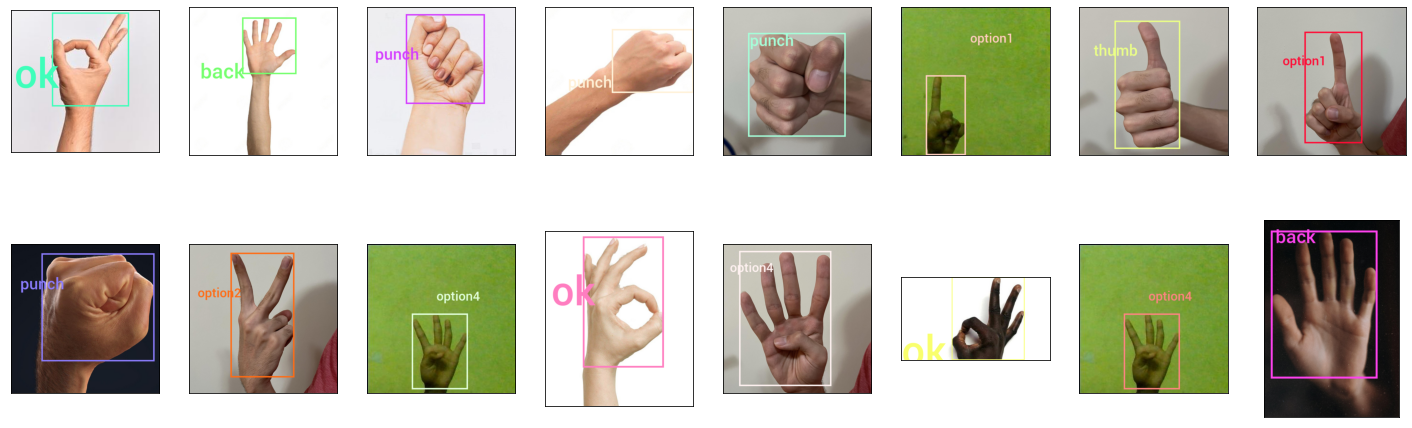

In [211]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(25, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  img = df_pascal.iloc[randrange(len(df_pascal)-1)]
  image = draw_image(img['path'], img['XMin'], img['XMax'], img['YMin'], img['YMax'], img['label'])
  ax.imshow(image)

## Model Training

There are six steps to training an object detection model:

**Step 1. Choose an object detection model archiecture.**

This tutorial uses the EfficientDet-Lite0 model. EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 37            | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 49            | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 69            | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 116           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 260           | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Pixel 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>


In [194]:
spec_lite0 = model_spec.get('efficientdet_lite0')
spec_lite1 = model_spec.get('efficientdet_lite1')
spec_lite2 = model_spec.get('efficientdet_lite2')
spec_lite3 = model_spec.get('efficientdet_lite3')
spec_lite4 = model_spec.get('efficientdet_lite4')

**Step 2. Load the dataset.**

Model Maker can take input data in the CSV format. However, since we used LabelImg for annotations, we can specify the `DataLoader` to use the PascalVOC format. Use the `object_detector.DataLoader.from_pascal_voc` method to load the dataset and split them into the training, validation and test images.

* Training images: These images are used to train the object detection model to recognize salad ingredients.
* Validation images: These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting). This is not included in our training but you can include it, same procedure as train & test set.
* Test images: These images are used to evaluate the final model performance.

Simply specify the path to your images and annotations for your training & testing data.

In [449]:
# check current working directory
os.getcwd()

'F:\\Downloads'

### Load the Train Set

In [177]:
path_to_train_images = 'your_path/data_for_object_detection/data'
path_to_train_xml = 'your_path/data_for_object_detection/xml'

train_data = object_detector.DataLoader.from_pascal_voc(path_to_train_images, path_to_train_xml,
                                                                   label_map={1: "option1",
                                                                              2: "option2",
                                                                              3: "option3",
                                                                              4: "option4",
                                                                              5: "punch",
                                                                              6: "thumb",
                                                                              7: "ok",
                                                                              8: "back"})

In [178]:
# check the number of images in your train dataset, as long as it is not 0, you are good
train_data.size

801

### Load the Test Set

In [192]:
path_to_test_images = 'your_path/data_for_object_detection/test/data'
path_to_test_xml = 'your_path/data_for_object_detection/test/xml'

test_data = object_detector.DataLoader.from_pascal_voc(path_to_test_images, path_to_test_xml,
                                                                   label_map={1: "option1",
                                                                              2: "option2",
                                                                              3: "option3",
                                                                              4: "option4",
                                                                              5: "punch",
                                                                              6: "thumb",
                                                                              7: "ok",
                                                                              8: "back"})

In [193]:
# check the number of images in your test dataset
test_data.size

79

**Step 3. Train the TensorFlow model with the training data.**

* The EfficientDet-Lite0 model uses `epochs = 50` by default, which means it will go through the training dataset 50 times. You can look at the validation accuracy during training and stop early to avoid overfitting.
* Set `batch_size = 8` here so you will see that it takes 100 steps to go through the 801 images in the training dataset.
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [212]:
lite0 = object_detector.create(train_data, model_spec=spec_lite0, batch_size=8, train_whole_model=True)

Epoch 1/50
100/100 [==============================] - 35s 212ms/step - det_loss: 1.4762 - cls_loss: 1.0656 - box_loss: 0.0082 - reg_l2_loss: 0.0641 - loss: 1.5403 - learning_rate: 0.0090 - gradient_norm: 2.0538
Epoch 2/50
100/100 [==============================] - 19s 185ms/step - det_loss: 0.8982 - cls_loss: 0.7096 - box_loss: 0.0038 - reg_l2_loss: 0.0642 - loss: 0.9624 - learning_rate: 0.0100 - gradient_norm: 3.2183
Epoch 3/50
100/100 [==============================] - 17s 169ms/step - det_loss: 0.6462 - cls_loss: 0.5243 - box_loss: 0.0024 - reg_l2_loss: 0.0644 - loss: 0.7106 - learning_rate: 0.0099 - gradient_norm: 3.0200
Epoch 4/50
100/100 [==============================] - 17s 167ms/step - det_loss: 0.5627 - cls_loss: 0.4488 - box_loss: 0.0023 - reg_l2_loss: 0.0645 - loss: 0.6272 - learning_rate: 0.0099 - gradient_norm: 2.9673
Epoch 5/50
100/100 [==============================] - 16s 158ms/step - det_loss: 0.4835 - cls_loss: 0.3905 - box_loss: 0.0019 - reg_l2_loss: 0.0647 - loss: 

In [217]:
lite1 = object_detector.create(train_data, model_spec=spec_lite1, batch_size=8, train_whole_model=True)

Epoch 1/50
100/100 [==============================] - 61s 428ms/step - det_loss: 1.4842 - cls_loss: 1.1035 - box_loss: 0.0076 - reg_l2_loss: 0.0716 - loss: 1.5558 - learning_rate: 0.0090 - gradient_norm: 2.3150
Epoch 2/50
100/100 [==============================] - 25s 252ms/step - det_loss: 0.8441 - cls_loss: 0.6830 - box_loss: 0.0032 - reg_l2_loss: 0.0718 - loss: 0.9159 - learning_rate: 0.0100 - gradient_norm: 3.7531
Epoch 3/50
100/100 [==============================] - 23s 227ms/step - det_loss: 0.6216 - cls_loss: 0.4999 - box_loss: 0.0024 - reg_l2_loss: 0.0721 - loss: 0.6937 - learning_rate: 0.0099 - gradient_norm: 3.3124
Epoch 4/50
100/100 [==============================] - 32s 322ms/step - det_loss: 0.5031 - cls_loss: 0.4116 - box_loss: 0.0018 - reg_l2_loss: 0.0723 - loss: 0.5753 - learning_rate: 0.0099 - gradient_norm: 3.0033
Epoch 5/50
100/100 [==============================] - 29s 285ms/step - det_loss: 0.4569 - cls_loss: 0.3744 - box_loss: 0.0017 - reg_l2_loss: 0.0724 - loss: 

In [ ]:
lite2 = object_detector.create(train_data, model_spec=spec_lite2, batch_size=8, train_whole_model=True)

In [219]:
lite3 = object_detector.create(train_data, model_spec=spec_lite3, batch_size=8, train_whole_model=True)

Epoch 1/50
100/100 [==============================] - 63s 421ms/step - det_loss: 1.4112 - cls_loss: 1.0654 - box_loss: 0.0069 - reg_l2_loss: 0.0937 - loss: 1.5049 - learning_rate: 0.0090 - gradient_norm: 3.3098
Epoch 2/50
100/100 [==============================] - 42s 422ms/step - det_loss: 0.7228 - cls_loss: 0.6066 - box_loss: 0.0023 - reg_l2_loss: 0.0939 - loss: 0.8167 - learning_rate: 0.0100 - gradient_norm: 3.8450
Epoch 3/50
100/100 [==============================] - 42s 424ms/step - det_loss: 0.5296 - cls_loss: 0.4452 - box_loss: 0.0017 - reg_l2_loss: 0.0942 - loss: 0.6238 - learning_rate: 0.0099 - gradient_norm: 3.6698
Epoch 4/50
100/100 [==============================] - 43s 427ms/step - det_loss: 0.4426 - cls_loss: 0.3757 - box_loss: 0.0013 - reg_l2_loss: 0.0945 - loss: 0.5371 - learning_rate: 0.0099 - gradient_norm: 3.3005
Epoch 5/50
100/100 [==============================] - 40s 402ms/step - det_loss: 0.4011 - cls_loss: 0.3395 - box_loss: 0.0012 - reg_l2_loss: 0.0946 - loss: 

In [221]:
try:
  lite4 = object_detector.create(train_data, model_spec=spec_lite4, batch_size=3, train_whole_model=True)
except:
  lite4 = object_detector.create(train_data, model_spec=spec_lite4, batch_size=2, train_whole_model=True)

Epoch 1/50
267/267 [==============================] - 133s 413ms/step - det_loss: 1.0672 - cls_loss: 0.8540 - box_loss: 0.0043 - reg_l2_loss: 0.1092 - loss: 1.1764 - learning_rate: 0.0059 - gradient_norm: 5.5858
Epoch 2/50
267/267 [==============================] - 111s 415ms/step - det_loss: 0.5645 - cls_loss: 0.4771 - box_loss: 0.0017 - reg_l2_loss: 0.1096 - loss: 0.6740 - learning_rate: 0.0037 - gradient_norm: 4.9918
Epoch 3/50
267/267 [==============================] - 112s 417ms/step - det_loss: 0.4747 - cls_loss: 0.4096 - box_loss: 0.0013 - reg_l2_loss: 0.1097 - loss: 0.5844 - learning_rate: 0.0037 - gradient_norm: 4.6012
Epoch 4/50
267/267 [==============================] - 109s 409ms/step - det_loss: 0.4282 - cls_loss: 0.3681 - box_loss: 0.0012 - reg_l2_loss: 0.1098 - loss: 0.5380 - learning_rate: 0.0037 - gradient_norm: 4.8646
Epoch 5/50
267/267 [==============================] - 130s 487ms/step - det_loss: 0.3787 - cls_loss: 0.3237 - box_loss: 0.0011 - reg_l2_loss: 0.1100 - l

**Step 4. Evaluate the model with the test data.**

After training the object detection model using the images in the training dataset, use the remaining 25 images in the test dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the 25 images in the test dataset.

The evaluation metrics are same as [COCO](https://cocodataset.org/#detection-eval).

In [216]:
lite0_results = lite0.evaluate(test_data, batch_size=8)
lite0_results

10/10 [==============================] - 5s 221ms/step



{'AP': 0.8252863,
 'AP50': 0.9416739,
 'AP75': 0.914654,
 'APs': -1.0,
 'APm': -1.0,
 'APl': 0.8253578,
 'ARmax1': 0.82625,
 'ARmax10': 0.885,
 'ARmax100': 0.885,
 'ARs': -1.0,
 'ARm': -1.0,
 'ARl': 0.885,
 'AP_/option1': 0.7087984,
 'AP_/option2': 0.85263634,
 'AP_/option3': 0.9021645,
 'AP_/option4': 0.7733878,
 'AP_/punch': 0.89384556,
 'AP_/thumb': 0.8190582,
 'AP_/ok': 0.7526629,
 'AP_/back': 0.89973706}

In [218]:
lite1_results = lite1.evaluate(test_data)
lite1_results

2/2 [==============================] - 11s 3s/step



{'AP': 0.8337193,
 'AP50': 0.93858576,
 'AP75': 0.9255801,
 'APs': -1.0,
 'APm': -1.0,
 'APl': 0.8337506,
 'ARmax1': 0.84125,
 'ARmax10': 0.88,
 'ARmax100': 0.88,
 'ARs': -1.0,
 'ARm': -1.0,
 'ARl': 0.88,
 'AP_/option1': 0.683847,
 'AP_/option2': 0.88074094,
 'AP_/option3': 0.90330034,
 'AP_/option4': 0.71971965,
 'AP_/punch': 0.8804275,
 'AP_/thumb': 0.8806569,
 'AP_/ok': 0.8031568,
 'AP_/back': 0.9179054}

In [41]:
lite2_results = lite2.evaluate(test_data)
lite2_results

2/2 [==============================] - 9s 2s/step



{'AP': 0.8695503,
 'AP50': 0.956028,
 'AP75': 0.9529703,
 'APs': -1.0,
 'APm': -1.0,
 'APl': 0.8695527,
 'ARmax1': 0.88090277,
 'ARmax10': 0.8980903,
 'ARmax100': 0.8980903,
 'ARs': -1.0,
 'ARm': -1.0,
 'ARl': 0.8980903,
 'AP_/option1': 0.69825244,
 'AP_/option2': 0.88044554,
 'AP_/option3': 0.89713126,
 'AP_/option4': 0.81905943,
 'AP_/punch': 0.90759075,
 'AP_/thumb': 0.92245877,
 'AP_/ok': 0.9084653,
 'AP_/back': 0.9229986}

In [220]:
lite3_results = lite3.evaluate(test_data, batch_size=4)
lite3_results

20/20 [==============================] - 7s 196ms/step



{'AP': 0.863767,
 'AP50': 0.9488871,
 'AP75': 0.9473072,
 'APs': -1.0,
 'APm': -1.0,
 'APl': 0.8637988,
 'ARmax1': 0.875,
 'ARmax10': 0.90125,
 'ARmax100': 0.90125,
 'ARs': -1.0,
 'ARm': -1.0,
 'ARl': 0.90125,
 'AP_/option1': 0.6926246,
 'AP_/option2': 0.8728021,
 'AP_/option3': 0.91400284,
 'AP_/option4': 0.8374487,
 'AP_/punch': 0.8712871,
 'AP_/thumb': 0.9346063,
 'AP_/ok': 0.8497638,
 'AP_/back': 0.9376008}

In [223]:
lite4_results = lite4.evaluate(test_data, batch_size=2)
lite4_results

40/40 [==============================] - 8s 116ms/step



{'AP': 0.87388265,
 'AP50': 0.95074505,
 'AP75': 0.94710094,
 'APs': -1.0,
 'APm': -1.0,
 'APl': 0.87419176,
 'ARmax1': 0.88875,
 'ARmax10': 0.91375,
 'ARmax100': 0.91375,
 'ARs': -1.0,
 'ARm': -1.0,
 'ARl': 0.91375,
 'AP_/option1': 0.73187566,
 'AP_/option2': 0.89383084,
 'AP_/option3': 0.9297305,
 'AP_/option4': 0.75427866,
 'AP_/punch': 0.9247903,
 'AP_/thumb': 0.9393666,
 'AP_/ok': 0.9440865,
 'AP_/back': 0.8731023}

**Step 5. Visualization**

Now that we are done with training and evaluation, let us visualise the results we have obtained in forms of tables and figures.

In [242]:
# add the name of each model to the results
lite0_results['name'] = 'EfficientNet-Lite0'
lite1_results['name'] = 'EfficientNet-Lite1'
lite2_results['name'] = 'EfficientNet-Lite2'
lite3_results['name'] = 'EfficientNet-Lite3'
lite4_results['name'] = 'EfficientNet-Lite4'

In [335]:
# create a dataframe from the results of each model training
df_results = pd.DataFrame([lite0_results,
              lite1_results,
              lite2_results,
              lite3_results,
              lite4_results])

cols = df_results.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_results = df_results[cols]
df_results = df_results.sort_values(by='AP')
cols_to_show = cols[0:4] + cols[-8:]
df_results[cols_to_show]

name        AP      AP50      AP75  AP_/option1  AP_/option2  \
0  EfficientNet-Lite0  0.825286  0.941674  0.914654     0.708798     0.852636   
1  EfficientNet-Lite1  0.833719  0.938586  0.925580     0.683847     0.880741   
3  EfficientNet-Lite3  0.863767  0.948887  0.947307     0.692625     0.872802   
2  EfficientNet-Lite2  0.869550  0.956028  0.952970     0.698252     0.880446   
4  EfficientNet-Lite4  0.873883  0.950745  0.947101     0.731876     0.893831   

   AP_/option3  AP_/option4  AP_/punch  AP_/thumb    AP_/ok  AP_/back  
0     0.902165     0.773388   0.893846   0.819058  0.752663  0.899737  
1     0.903300     0.719720   0.880427   0.880657  0.803157  0.917905  
3     0.914003     0.837449   0.871287   0.934606  0.849764  0.937601  
2     0.897131     0.819059   0.907591   0.922459  0.908465  0.922999  
4     0.929730     0.754279   0.924790   0.939367  0.944086  0.873102

In [308]:
colors=mcp.gen_color(cmap="flare_r",n=5)
print(colors)

['#4b2362', '#873171', '#c24167', '#e5725f', '#edb081']


### Plot the Testing mAP

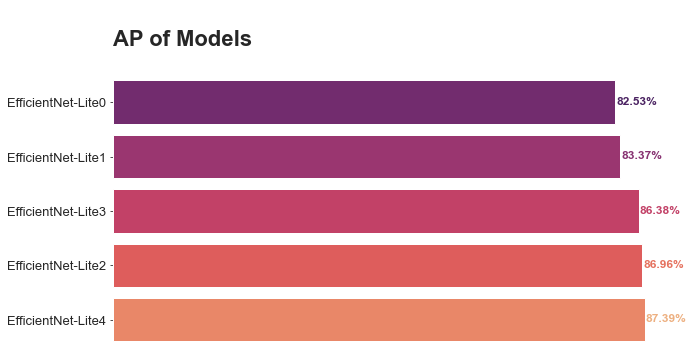

In [324]:
plt.figure(figsize=(10,5))
sns.set_style('ticks')
ax = sns.barplot(y=df_results.name, x=df_results.AP, palette = "flare_r", saturation = 1.0)
plt.title('\nAP of Models\n', fontsize=22, weight='bold', loc='left')
ax.set_frame_on(False)
ax.set_xticks([])
plt.ylabel('')
plt.xlabel('')

plt.yticks(fontsize=13)
j = 0
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(width*100,2)}%', (x + width+0.035, y + height*0.55), ha='center', fontsize=12, color=colors[j], weight='bold')#, weight='bold')
    j += 1
plt.show()

In [ ]:
model.export(export_dir='.')

In [346]:
df_results

name        AP      AP50      AP75  APs  APm       APl  \
0  EfficientNet-Lite0  0.825286  0.941674  0.914654 -1.0 -1.0  0.825358   
1  EfficientNet-Lite1  0.833719  0.938586  0.925580 -1.0 -1.0  0.833751   
3  EfficientNet-Lite3  0.863767  0.948887  0.947307 -1.0 -1.0  0.863799   
2  EfficientNet-Lite2  0.869550  0.956028  0.952970 -1.0 -1.0  0.869553   
4  EfficientNet-Lite4  0.873883  0.950745  0.947101 -1.0 -1.0  0.874192   

     ARmax1  ARmax10  ARmax100  ...  ARm      ARl  AP_/option1  AP_/option2  \
0  0.826250  0.88500   0.88500  ... -1.0  0.88500     0.708798     0.852636   
1  0.841250  0.88000   0.88000  ... -1.0  0.88000     0.683847     0.880741   
3  0.875000  0.90125   0.90125  ... -1.0  0.90125     0.692625     0.872802   
2  0.880903  0.89809   0.89809  ... -1.0  0.89809     0.698252     0.880446   
4  0.888750  0.91375   0.91375  ... -1.0  0.91375     0.731876     0.893831   

   AP_/option3  AP_/option4  AP_/punch  AP_/thumb    AP_/ok  AP_/back  
0     0.902165     0.773388   0.893846   0.819058  0.752663  0.899737  
1     0.903300     0.719720   0.880427   0.880657  0.803157  0.917905  
3     0.914003     0.837449   0.871287   0.934606  0.849764  0.937601  
2     0.897131     0.819059   0.907591   0.922459  0.908465  0.922999  
4     0.929730     0.754279   0.924790   0.939367  0.944086  0.873102  

[5 rows x 21 columns]

**Step 6.  Export as a TensorFlow Lite model.**

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is full integer quantization.

In [336]:
lite0.export(export_dir='your_path/data_for_object_detection/tflite/lite0/', export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])

In [337]:
lite1.export(export_dir='your_path/data_for_object_detection/tflite/lite1/', export_format=[ExportFormat.TFLITE])

In [338]:
lite2.export(export_dir='your_path/data_for_object_detection/tflite/lite2/', export_format=[ExportFormat.TFLITE])

In [339]:
lite3.export(export_dir='your_path/data_for_object_detection/tflite/lite3/', export_format=[ExportFormat.TFLITE])

In [340]:
lite4.export(export_dir='your_path/data_for_object_detection/tflite/lite4/', export_format=[ExportFormat.TFLITE])

In [ ]:
# path to the exported tflite model
model_path = 'your_path/data_for_object_detection/tflite/lite0/model.tflite'

In [451]:
#@title Load the trained TFLite model for infering custom images

import cv2
from PIL import Image

# Load the labels into a list
classes = ['???'] * lite0.model_spec.config.num_classes
label_map = lite0.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

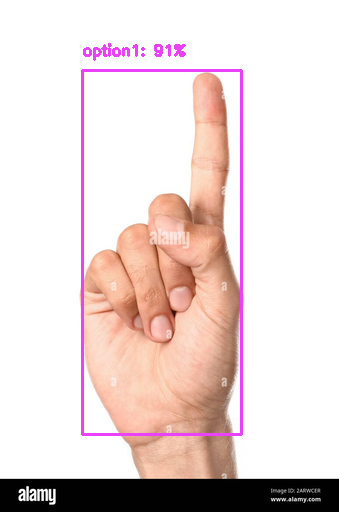

In [450]:
#@title Run object detection on custom image
import requests
from io import BytesIO
from PIL import Image

INPUT_IMAGE_URL = "https://c8.alamy.com/comp/2ARWCER/male-hand-with-raised-index-finger-on-white-background-2ARWCER.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.3 #@param {type:"number"}

TEMP_FILE = 'F:/Downloads/img.png'

#!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
response = requests.get(INPUT_IMAGE_URL)
im = Image.open(BytesIO(response.content))
#im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

## Additional Information

---


### Customize the EfficientDet model hyperparameters

The model and training pipline parameters you can adjust are:

* `model_dir`: The location to save the model checkpoint files. If not set, a temporary directory will be used.
* `steps_per_execution`: Number of steps per training execution.
* `moving_average_decay`: Float. The decay to use for maintaining moving averages of the trained parameters.
* `var_freeze_expr`: The regular expression to map the prefix name of variables to be frozen which means remaining the same during training. More specific, use `re.match(var_freeze_expr, variable_name)` in the codebase to map the variables to be frozen.
* `tflite_max_detections`: integer, 25 by default. The max number of output detections in the TFLite model.
* `strategy`:  A string specifying which distribution strategy to use. Accepted values are 'tpu', 'gpus', None. tpu' means to use TPUStrategy. 'gpus' mean to use MirroredStrategy for multi-gpus. If None, use TF default with OneDeviceStrategy.
* `tpu`:  The Cloud TPU to use for training. This should be either the name used when creating the Cloud TPU, or a grpc://ip.address.of.tpu:8470 url.
* `use_xla`: Use XLA even if strategy is not tpu. If strategy is tpu, always use XLA, and this flag has no effect.
* `profile`: Enable profile mode.
* `debug`: Enable debug mode.

Other parameters that can be adjusted is shown in [hparams_config.py](https://github.com/google/automl/blob/df451765d467c5ed78bbdfd632810bc1014b123e/efficientdet/hparams_config.py#L170).


For instance, you can set the `var_freeze_expr='efficientnet'` which freezes the variables with name prefix `efficientnet` (default is `'(efficientnet|fpn_cells|resample_p6)'`). This allows the model to freeze untrainable variables and keep their value the same through training.

```python
spec = model_spec.get('efficientdet_lite0')
spec.config.var_freeze_expr = 'efficientnet'
```

### Customize Post-training quantization on the TensorFlow Lite model

[Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) is a conversion technique that can reduce model size and inference latency, while also improving CPU and hardware accelerator inference speed, with a little degradation in model accuracy. Thus, it's widely used to optimize the model.

Model Maker library applies a default post-training quantization techique when exporting the model. If you want to customize post-training quantization, Model Maker supports multiple post-training quantization options using [QuantizationConfig](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/config/QuantizationConfig) as well. Let's take float16 quantization as an instance. First, define the quantization config.

```python
config = QuantizationConfig.for_float16()
```


Then we export the TensorFlow Lite model with such configuration.

```python
model.export(export_dir='.', tflite_filename='model_fp16.tflite', quantization_config=config)
```

# Read more

You can read our [object detection](https://www.tensorflow.org/lite/examples/object_detection/overview) example to learn technical details. For more information, please refer to:

*   TensorFlow Lite Model Maker [guide](https://www.tensorflow.org/lite/models/modify/model_maker) and [API reference](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker).
*   Task Library: [ObjectDetector](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) for deployment.
*   The end-to-end reference apps: [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android), [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/ios), and [Raspberry PI](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

